## Python Example for denoising speech(Wiener Filter):

* Importing the relevant modules

In [1]:
%matplotlib inline
from sound import *
from scipy import signal as sp
import numpy as np
import matplotlib.pyplot as plt

* Extracting audio information from a given speech signal

In [2]:
x, fs = wavread('speech8kHz.wav')

('Number of channels: ', 1)
('Number of bytes per sample:', 2)
('Sampling rate: ', 8000)
('Number of samples:', 60246)


* Make x a matrix and transpose it into a column:

In [3]:
x = np.matrix(x).T

* Playback the audio
  * convert 'x' to array type as sound function expects array vector but not a matrix

In [4]:
sound(np.array(x), fs)

C:\Users\vijay\workspace\DSP\modules\sound.py:32: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  data=struct.pack('h' * CHUNK, *samples);


* done


**Note:** Ignore the warning

* Additive zero mean white noise (for $-2^{15}<x<+2^{15}$):

In [5]:
y = x + 0.1 * (np.random.random(np.shape(x)) - 0.5) * 2 ** 15

In [6]:
sound(np.array(y), fs)

* done


* We assume 10 coefficients for our Wiener filter. 10 to 12 is a good number for speech signals.

In [7]:
A = np.matrix(np.zeros((60230, 10)))

for m in range(60230):
    A[m,:] = y[m+np.arange(10)].T

**Note:** Taking 60230 long matrix is just based on approximation as the signal(used here in this example) has 60246 samples, so choosing some closer value.

* Our matrix has 60200 rows and 10 colums:

In [8]:
print A.shape

(60230, 10)


### Compute Wiener Filter:
**Trick:** allow (ﬂipped) filter delay of 5 samples to get better working denoising. This corresponds to the center of our Wiener filter. <br/>
The desired signal hence is x[5:60235].

Observe: Since we have the matrix type, operator  $„*“$ is matrix multiplication!

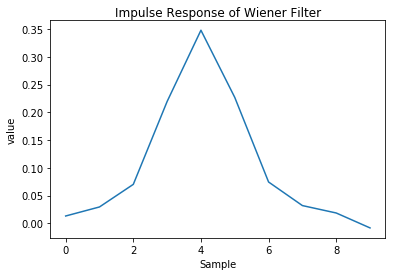

In [9]:
h = np.linalg.inv(A.T*A)*A.T*x[5:60235]
plt.plot(np.flipud(h))
plt.xlabel('Sample')
plt.ylabel('value')
plt.title('Impulse Response of Wiener Filter')

> Observe that for this non-ﬂipped impulse response we see has a delay of 4 samples (the peak is a sample number 4).

Its frequency response is

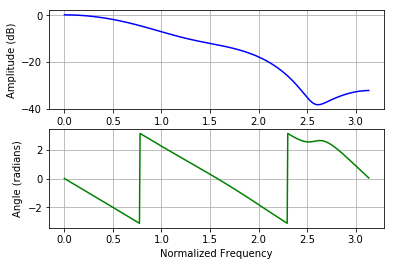

In [10]:
from freqz import *
freqz(np.flipud(h))

Here we can see that the resulting filter has a somewhat **low pass characteristics**, because our speech signal has energy mostly at low frequencies. At high frequencies we have mostly noise, hence it makes sense to have more attenuation there! This attenuation curve of this Wiener filter also has some similarity to the speech spectrum. If we compare it with the spectrum of our white noise, then we see that at low frequencies the speech is dominatng, and at high frequencies noise is dominatng. hence we need to
remove or attenuate that later, noisy, part of the spectrum.

We can plot the spectra of the speech and the noise together with (this time with the freqz from the signal processing library, without the build in plotting):

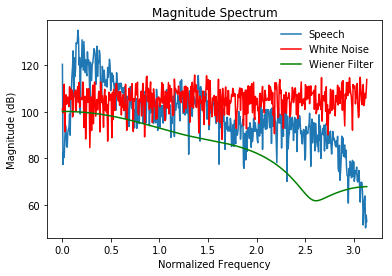

In [11]:
w, Hspeech = sp.freqz(x);
w, Hnoise = sp.freqz(0.1*(np.random.random(np.shape(x)) - 0.5) * 2 ** 15)
w, Hw = sp.freqz(np.flipud(h))
plt.plot(w, 20 * np.log10(np.abs(Hspeech)))
plt.hold
plt.plot(w, 20 * np.log10(np.abs(Hnoise)),'r')
#plot and shift the filter into the vicinity of the signal:
plt.plot(w, 20 * np.log10(np.abs(Hw)) + 100,'g');
plt.xlabel('Normalized Frequency')
plt.ylabel('Magnitude (dB)')
plt.legend(('Speech', 'White Noise', 'Wiener Filter'))
plt.title('Magnitude Spectrum')

Here we see that **speech dominates the spectrum only at low and middle frequencies**, noise at the other frequencies, hence it makes sense to suppress those noisy frequencies. Now we can filter it. For “lfilter” function argument we need to convert the matrix type into a 1 dimensional array type:

In [12]:
xw = sp.lfilter(np.array(np.flipud(h).T)[0], [1], np.array(y.T)[0])

* and listen to it:

In [13]:
sound(xw, fs)

* done


We can hear that the signal now sounds more “muffled”, the higher frequencies are indeed attenuated, which reduces the inﬂuence of the noise. But it is still a question if it actually “sounds” better to the human ear. This Wiener filter could now also be applied to **other speech signals**, with **similar frequency characteristics** for signal and noise.

* Let's compare the mean quadratic error. For the noisy signal it is

In [14]:
print np.shape(x)

(60246, 1)


* Compute the quadratic error for the first 50000 samples:

In [15]:
np.sum(np.power(y[:50000]-x[:50000],2))/50000

893601.99640969839

For the Wiener filtered signal it is (taking into account 4 samples delay from our filter, beginning to peak).

In [16]:
np.sum(np.power(xw[4:50004] - x[:50000].T,2))/50000

313536.88929967943

We can see that the mean quadratic error is indeed less than half as much as for the noisy version y(n)!